In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random
import math
import os
import sys
import csv
import time

data = pd.read_csv("data_OptiMinds.csv")  
# Convert fractional years to datetime to understand the data better
def fractional_year_to_date(year):
    year_int = int(year)
    remainder = year - year_int
    start_of_year = datetime.datetime(year_int, 1, 1)
    days_in_year = (datetime.datetime(year_int + 1, 1, 1) - start_of_year).days
    return start_of_year + datetime.timedelta(days=remainder * days_in_year)

# Apply conversion
data['Date'] = data['Time'].apply(fractional_year_to_date)

subset_random = data.sample(n=1000, random_state=42)
print(subset_random.head())

              Time          SN                       Date
3318   1764.202980   61.059679 1764-03-15 06:58:50.319951
32638  1845.646723   43.003447 1845-08-25 01:17:44.775877
27227  1830.616297   82.596295 1830-08-13 22:45:48.499199
24615  1823.360804    0.000000 1823-05-12 16:38:39.795686
29045  1835.666254  132.597282 1835-09-01 04:22:56.440623


In [13]:
# Extract and sort time points and observed values
subset_random = subset_random.sort_values(by="Time")
t = subset_random['Time'].values
observed_values = subset_random['SN'].values

### Solar function & MSE

In [14]:
def solar_cycle_model(t, params, num_cycles=10):
    """
    Models the solar cycles based on the given parameters, ensuring distinct parameters for each cycle.
    
    Args:
        t (ndarray): Array of time points.
        params (ndarray): Array of 3*num_cycles parameters 
                          [T0_1, Ts_1, Td_1, ..., T0_n, Ts_n, Td_n].
        num_cycles (int): Number of solar cycles (default is 10).
     
    Returns:
        ndarray: Predicted values of x(t).
    """
    assert isinstance(params, (np.ndarray, list)), "params must be a NumPy array or list"
    assert len(params) == 3 * num_cycles, f"params length must be 3 * num_cycles, got {len(params)}"

    predicted_values = np.zeros_like(t)
    for k in range(num_cycles):
        T0 = params[3 * k]
        Ts = params[3 * k + 1]
        Td = params[3 * k + 2]

        if k < num_cycles - 1:
            next_T0 = params[3 * (k + 1)]
            cycle_mask = (t >= T0) & (t < next_T0)
        else:
            cycle_mask = (t >= T0)

        t_cycle = t[cycle_mask]
        if len(t_cycle) > 0:
            x_k = ((t_cycle - T0) / Ts) ** 2 * np.exp(-((t_cycle - T0) / Td) ** 2)
            predicted_values[cycle_mask] += x_k
    return predicted_values


# Loss Function: Mean Squared Error
def mse(params, t, observed_values):
    """
    Computes the Mean Squared Error (MSE) between observed data and model predictions.
    
    Args:
        params (ndarray): Model parameters [T0_1, Ts_1, Td_1, ..., T0_n, Ts_n, Td_n].
        t (ndarray): Time points of the observations.
        observed_values (ndarray): Observed sunspot data.
    
    Returns:
        float: The MSE value.
    """
    def mse(params, t, observed_values):
        print(f"Params type: {type(params)}, Params: {params}")
        assert isinstance(params, (np.ndarray, list)), "params must be a NumPy array or list"
        predicted_values = solar_cycle_model(t, params, num_cycles=len(T0_initial))
        return np.mean((observed_values - predicted_values) ** 2)


### Simulated annealing

In [15]:
def simulated_annealing(x0, T0, sigma, f, n_iter=10000, burn_in=5000):
    """
    Performs Simulated Annealing to optimize the solar cycle parameters.
    
    Args:
        x0 (ndarray): Initial parameter guess.
        T0 (float): Initial temperature.
        sigma (float): Proposal standard deviation.
        f (function): Loss function to minimize.
        n_iter (int): Total number of iterations.
        burn_in (int): Burn-in period.
    
    Returns:
        tuple: Optimized parameters and loss function evolution.
    """
    x = x0.copy()
    n_params = len(x0)
    temperature = T0
    losses = []
    best_x = x.copy()
    best_loss = f(x)

    for i in range(n_iter):
        # Propose new parameters
        x_new = x + np.random.normal(0, sigma, size=n_params)
        
        # Calculate the loss difference
        loss_old = f(x)
        loss_new = f(x_new)
        delta_e = loss_new - loss_old
        
        # Metropolis criterion
        if np.exp(-delta_e / temperature) >= np.random.rand():
            x = x_new
            if loss_new < best_loss:
                best_loss = loss_new
                best_x = x_new.copy()
        
        # Cool the temperature
        temperature = T0 / (1 + i / n_iter)
        losses.append(loss_old)
    
    # Discard burn-in period
    return best_x, np.array(losses[burn_in:])

Testing with initial parameters

In [16]:
# Initial parameters from the paper
T0_initial = np.array([1755.2, 1766.06, 1775.5, 1784.9, 1798.4, 
                       1810.6, 1823.05, 1833.11, 1843.5, 1855.12])
Ts_initial = np.full(len(T0_initial), 0.3)
Td_initial = np.full(len(T0_initial), 5.0)

x0 = np.empty(len(T0_initial) * 3)
x0[::3] = T0_initial
x0[1::3] = Ts_initial
x0[2::3] = Td_initial

print("Initial Parameters:", x0)

Initial Parameters: [1.75520e+03 3.00000e-01 5.00000e+00 1.76606e+03 3.00000e-01 5.00000e+00
 1.77550e+03 3.00000e-01 5.00000e+00 1.78490e+03 3.00000e-01 5.00000e+00
 1.79840e+03 3.00000e-01 5.00000e+00 1.81060e+03 3.00000e-01 5.00000e+00
 1.82305e+03 3.00000e-01 5.00000e+00 1.83311e+03 3.00000e-01 5.00000e+00
 1.84350e+03 3.00000e-01 5.00000e+00 1.85512e+03 3.00000e-01 5.00000e+00]


### Run Siumlated Annealing

In [17]:
loss_function = lambda params: mse(params, t, observed_values)
optimized_params, loss_curve = simulated_annealing(
    x0, T0=10, sigma=0.1, f=loss_function, n_iter=10000, burn_in=5000
)
predicted_values = solar_cycle_model(t, optimized_params, num_cycles=len(T0_initial))

TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

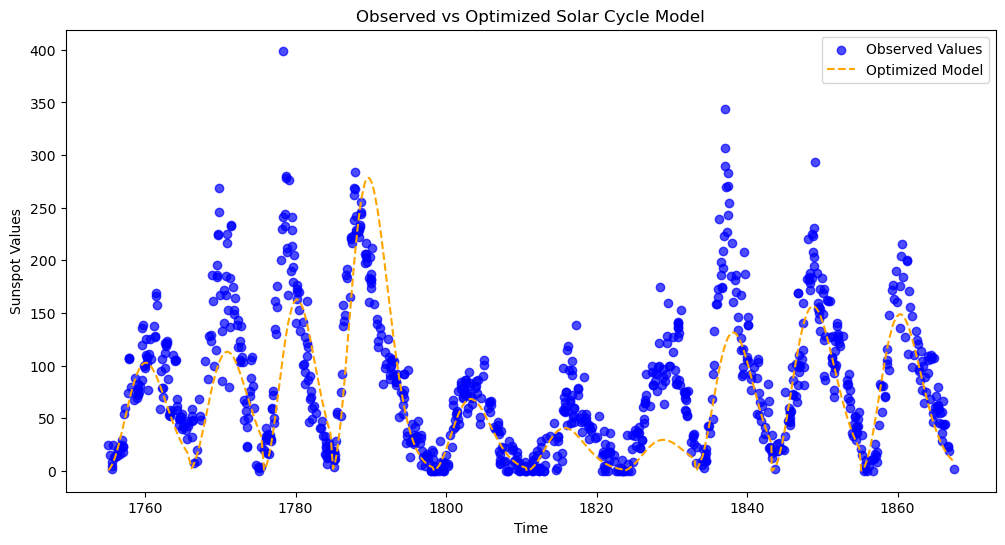

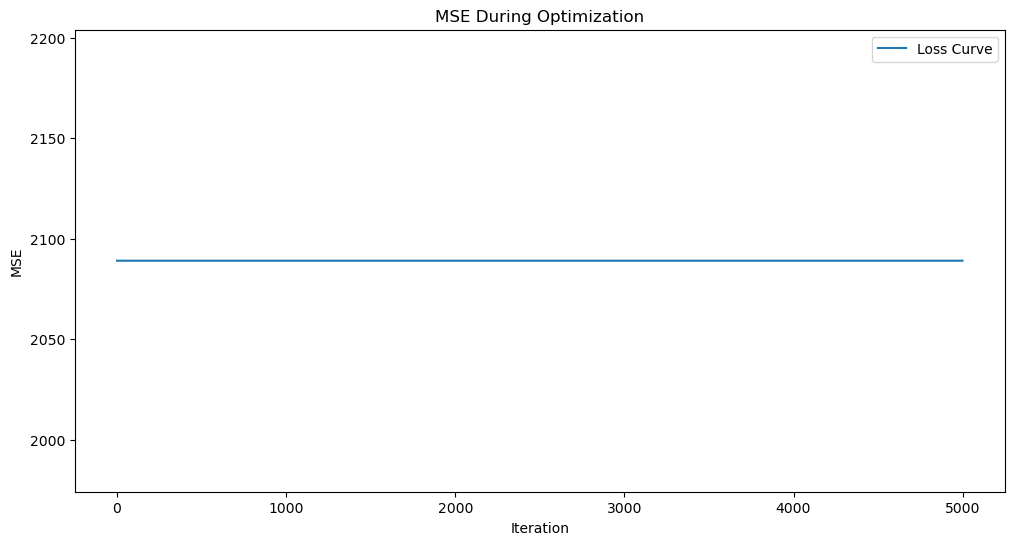

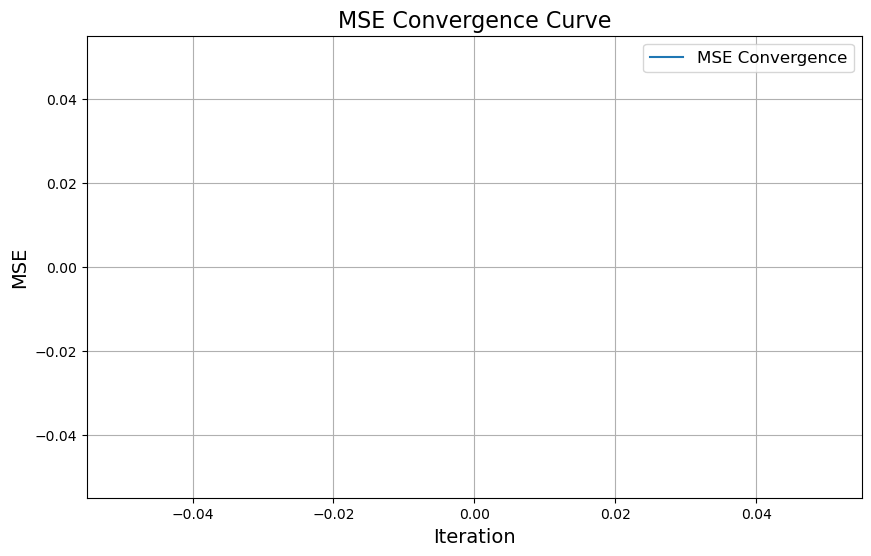

Final MSE: None


In [10]:
# Observed vs Optimized Model
plt.figure(figsize=(12, 6))
plt.scatter(t, observed_values, label="Observed Values", color="blue", alpha=0.7)
plt.plot(t, predicted_values, label="Optimized Model", color="orange", linestyle="--")
plt.legend()
plt.title("Observed vs Optimized Solar Cycle Model")
plt.xlabel("Time")
plt.ylabel("Sunspot Values")
plt.show()

# MSE Convergence During Optimization
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(loss_curve)), loss_curve, label="Loss Curve")
plt.title("MSE During Optimization")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()

# Final MSE Curve
mse_curve = [mse(params, t, observed_values) for params in optimized_params]


plt.figure(figsize=(10, 6))
plt.plot(mse_curve, label="MSE Convergence")
plt.title("MSE Convergence Curve", fontsize=16)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("MSE", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Print Final MSE
final_mse = mse(optimized_params[-1], t, observed_values)
print(f"Final MSE: {final_mse}")

In [ ]:
# Inside simulated_annealing loop
for i in range(n_iter):
    x_new = x + np.random.normal(0, sigma, size=n_params)
    loss_old = f(x)
    loss_new = f(x_new)

    # Print diagnostics
    print(f"Iteration {i}, Loss Old: {loss_old}, Loss New: {loss_new}")

    # Metropolis criterion
    if np.exp(-delta_e / temperature) >= np.random.rand():
        x = x_new
        if loss_new < best_loss:
            best_loss = loss_new
            best_x = x_new.copy()


In [ ]:
# Plot MSE Convergence Curve
plt.figure(figsize=(10, 6))

# Compute MSE for each set of optimized parameters
mse_curve = [mse(params, t, observed_values) for params in optimized_params]

# Plot the MSE Curve
plt.plot(mse_curve, label="MSE Convergence")
plt.title("MSE Convergence During Optimization", fontsize=16)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("MSE", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Print MSE for the final optimized parameters
final_mse = mse(optimized_params[-1], t, observed_values)
print(f"Final MSE: {final_mse}")


Run simulated annealing

In [ ]:

# Compute predictions using the model for all cycles
num_cycles = len(T0_initial)  # Number of cycles based on initial parameters
predicted_values = solar_cycle_model(t, x0, num_cycles=num_cycles)

Hyperparameter tuning

In [ ]:
# Define the loss function with fixed arguments
loss_function = lambda params: mse(params, t, observed_values)

# Step 1: Run Simulated Annealing
optimized_params, loss_curve = simulated_annealing(
    x0, T0=10, sigma=0.1, f=loss_function, n_iter=10000, burn_in=5000
)

# Step 2: Predicted values with optimized parameters
final_params = optimized_params
predicted_values = solar_cycle_model(t, final_params, num_cycles=num_cycles)

# Step 3: Plot observed vs. optimized model
plt.figure(figsize=(12, 6))
plt.scatter(t, observed_values, label="Observed Values", color="blue", alpha=0.7)
plt.plot(t, predicted_values, label="Optimized Model", color="orange", linestyle="--")
plt.legend()
plt.title("Observed vs. Optimized Model")
plt.xlabel("Time")
plt.ylabel("Sunspot Number")
plt.show()

# Step 4: Plot MSE convergence during optimization
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(loss_curve)), loss_curve, label="Loss Curve")
plt.title("MSE During Optimization")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()

# Step 5: Plot MSE for parameter convergence
plt.figure()
mse_curve = [mse(p, t, observed_values) for p in optimized_params]
plt.plot(mse_curve)
plt.title("MSE for Parameter Convergence")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.show()

# Step 6: Print MSE for the final optimized state
final_mse = mse(final_params, t, observed_values)
print(f"Final MSE: {final_mse}")


Hyperparameters tuning ---> löschen

In [ ]:
def tune_hyperparameters(x0, T0_vals, sigma_vals, f, n_iter=10000, burn_in=5000):
    """
    Tunes hyperparameters (T0 and sigma) for simulated annealing.

    Args:
        x0 (ndarray): Initial parameter guess.
        T0_vals (list): List of initial temperature values to test.
        sigma_vals (list): List of proposal standard deviations to test.
        f (function): Loss function to minimize.
        n_iter (int): Total number of iterations for simulated annealing.
        burn_in (int): Burn-in period for simulated annealing.

    Returns:
        dict: A dictionary containing the best T0, sigma, and corresponding MSE.
    """
    best_mse = float("inf")
    best_T0 = None
    best_sigma = None
    best_params = None
    
    results = []

    print("Starting hyperparameter tuning...")

    for T0 in T0_vals:
        for sigma in sigma_vals:
            print(f"Testing T0={T0}, sigma={sigma}...")
            
            # Define the loss function with arguments fixed
            loss_function = lambda params: mse(params, t, observed_values)
            
            # Run simulated annealing
            params, _ = simulated_annealing(x0, T0, sigma, loss_function, n_iter, burn_in)
            
            # Compute final MSE
            mse_value = loss_function(params)
            results.append({"T0": T0, "sigma": sigma, "mse": mse_value})

            print(f"T0={T0}, sigma={sigma}, MSE={mse_value}")

            # Update best hyperparameters if current MSE is lower
            if mse_value < best_mse:
                best_mse = mse_value
                best_T0 = T0
                best_sigma = sigma
                best_params = params
    
    print("Hyperparameter tuning complete.")
    print(f"Best T0={best_T0}, Best sigma={best_sigma}, Best MSE={best_mse}")
    
    return {
        "best_T0": best_T0,
        "best_sigma": best_sigma,
        "best_params": best_params,
        "best_mse": best_mse,
        "results": results
    }

# TODO: read paper for correct values

In [ ]:
T0_vals = [1, 5, 10]  # Example initial temperature values
sigma_vals = [0.1, 0.5, 1.0]  # Example proposal standard deviations


# Define the loss function with fixed arguments
loss_function = lambda params: mse(params, t, observed_values)

# Tune hyperparameters
tuning_results = tune_hyperparameters(x0, T0_vals, sigma_vals, loss_function, n_iter=10000, burn_in=5000)

# Extract the best hyperparameters and parameters
best_T0 = tuning_results["best_T0"]
best_sigma = tuning_results["best_sigma"]
best_params = tuning_results["best_params"]
best_mse = tuning_results["best_mse"]

print(f"Best Hyperparameters: T0={best_T0}, sigma={best_sigma}")
print(f"Best Parameters: {best_params}")
print(f"Best MSE: {best_mse}")


In [ ]:
# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(tuning_results["results"])

# Plot the MSE for different combinations of T0 and sigma
pivot_table = results_df.pivot("T0", "sigma", "mse")
plt.figure(figsize=(8, 6))
plt.title("MSE for Hyperparameter Combinations")
plt.xlabel("sigma")
plt.ylabel("T0")
plt.imshow(pivot_table, cmap="viridis", origin="lower")
plt.colorbar(label="MSE")
plt.xticks(range(len(sigma_vals)), sigma_vals)
plt.yticks(range(len(T0_vals)), T0_vals)
plt.show()

In [ ]:

# 99% to delete --> simplified version


# Define the loss function with additional arguments
loss_function = lambda params: mse(params, t, observed_values)

# Optimize parameters
optimized_params, loss_curve = simulated_annealing(x0, T0, sigma, loss_function, n_iter=10000, burn_in=5000)

# Tune hyperparameters
tuning_results = tune_hyperparameters(x0, T0_vals, sigma_vals, loss_function, n_iter=10000, burn_in=5000)
